<a href="https://colab.research.google.com/github/nickelodeon20/UG.Research-Yazhou.Tu-AU/blob/main/EEG-Data-Models/EEGNet/EEGNet__211data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Imagery Task Classification


#Extracting Data

##Downloading BCI Competition IV 2a Dataset

#Installing Packages

#Libraries Used

In [ ]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Building Dataset

##First Session

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import mne

# Data file folder path
data_folder = './data_211/refined_data/'

# Get all EEG data files
eeg_files = sorted(glob.glob(os.path.join(data_folder, '211_*.csv')))

# Define channel names and sampling frequency
channel_names = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5',
                 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
                 'EEG.F8', 'EEG.AF4']

sfreq = 128.0  # Sampling frequency (Hz)

# List to store each processed Raw object
raw_list = []

# Iterate over each EEG data file
for eeg_file in eeg_files:
    print(f"Processing EEG file: {eeg_file}")

    # Determine label based on filename
    if '211_r' in os.path.basename(eeg_file):
        label = 0  # Right
    elif '211_l' in os.path.basename(eeg_file):
        label = 1  # Left
    else:
        continue  # Skip files that don't match the pattern

    # Read EEG data file
    eeg_df = pd.read_csv(eeg_file, skiprows=1)

    # Select rows from 256 to 1280
    # eeg_df = eeg_df.iloc[256:1281]

    # Transposed data shape is (n_channels, n_times)
    data = eeg_df[channel_names].values.T

    # Create MNE info object
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

    # Generate RawArray object
    raw = mne.io.RawArray(data, info)

    # Create annotation based on the label
    annotations = mne.Annotations(onset=[2], duration=[8], description=[str(label)])
    raw.set_annotations(annotations)

    # Data preprocessing
    raw.filter(l_freq=4, h_freq=40, method='iir')  # Band-pass filter (4-40 Hz)
    raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering

    # Append processed raw object to list
    raw_list.append(raw)

# Concatenate all Raw objects
if len(raw_list) > 0:
    combined_raw = mne.concatenate_raws(raw_list)
else:
    raise ValueError("No Raw objects to combine.")

# Define output folder
output_folder = '/211_data_output/'
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, 'combined_test.fif')

# Save combined raw object to a .fif file
combined_raw.save(output_file, overwrite=True)
print(f"Saved FIF file to: {output_file}")


Processing EEG file: ./data_211/refined_data\211_l_EPOCX_266139_2025.02.11T16.09.14.06.00.md.csv
Creating RawArray with float64 data, n_channels=14, n_times=1634
    Range : 0 ... 1633 =      0.000 ...    12.758 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper trans

C:\Users\User\AppData\Local\Temp\ipykernel_33848\4054148145.py:53: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
C:\Users\User\AppData\Local\Temp\ipykernel_33848\4054148145.py:57: RuntimeWarning: filter_length (845) is longer than the signal (726), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


    Range : 0 ... 1540 =      0.000 ...    12.031 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Processing EEG file: ./data_211/refined_data\211_l_EPOCX_26613

C:\Users\User\AppData\Local\Temp\ipykernel_33848\4054148145.py:53: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
C:\Users\User\AppData\Local\Temp\ipykernel_33848\4054148145.py:57: RuntimeWarning: filter_length (845) is longer than the signal (314), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


    Range : 0 ... 1684 =      0.000 ...    13.156 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Processing EEG file: ./data_211/refined_data\211_r_EPOCX_26613

C:\Users\User\AppData\Local\Temp\ipykernel_33848\4054148145.py:74: RuntimeWarning: This filename (c:\211_data_output\combined_test.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  combined_raw.save(output_file, overwrite=True)


Closing c:\211_data_output\combined_test.fif
[done]
Saved FIF file to: /211_data_output/combined_test.fif


In [ ]:
print(combined_raw.annotations)


<Annotations | 598 segments: 0 (101), 1 (99), BAD boundary (199), EDGE ...>


Opening raw data file /211_data_output/combined_test.fif...
Isotrak not found
    Range : 0 ... 312232 =      0.000 ...  2439.312 secs
Ready.
Reading 0 ... 312232  =      0.000 ...  2439.312 secs...
<Info | 9 non-empty values
 bads: []
 ch_names: EEG.AF3, EEG.F7, EEG.F3, EEG.FC5, EEG.T7, EEG.P7, EEG.O1, ...
 chs: 14 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 4.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>


C:\Users\User\AppData\Local\Temp\ipykernel_8484\1540319902.py:6: RuntimeWarning: This filename (/211_data_output/combined_test.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Using matplotlib as 2D backend.


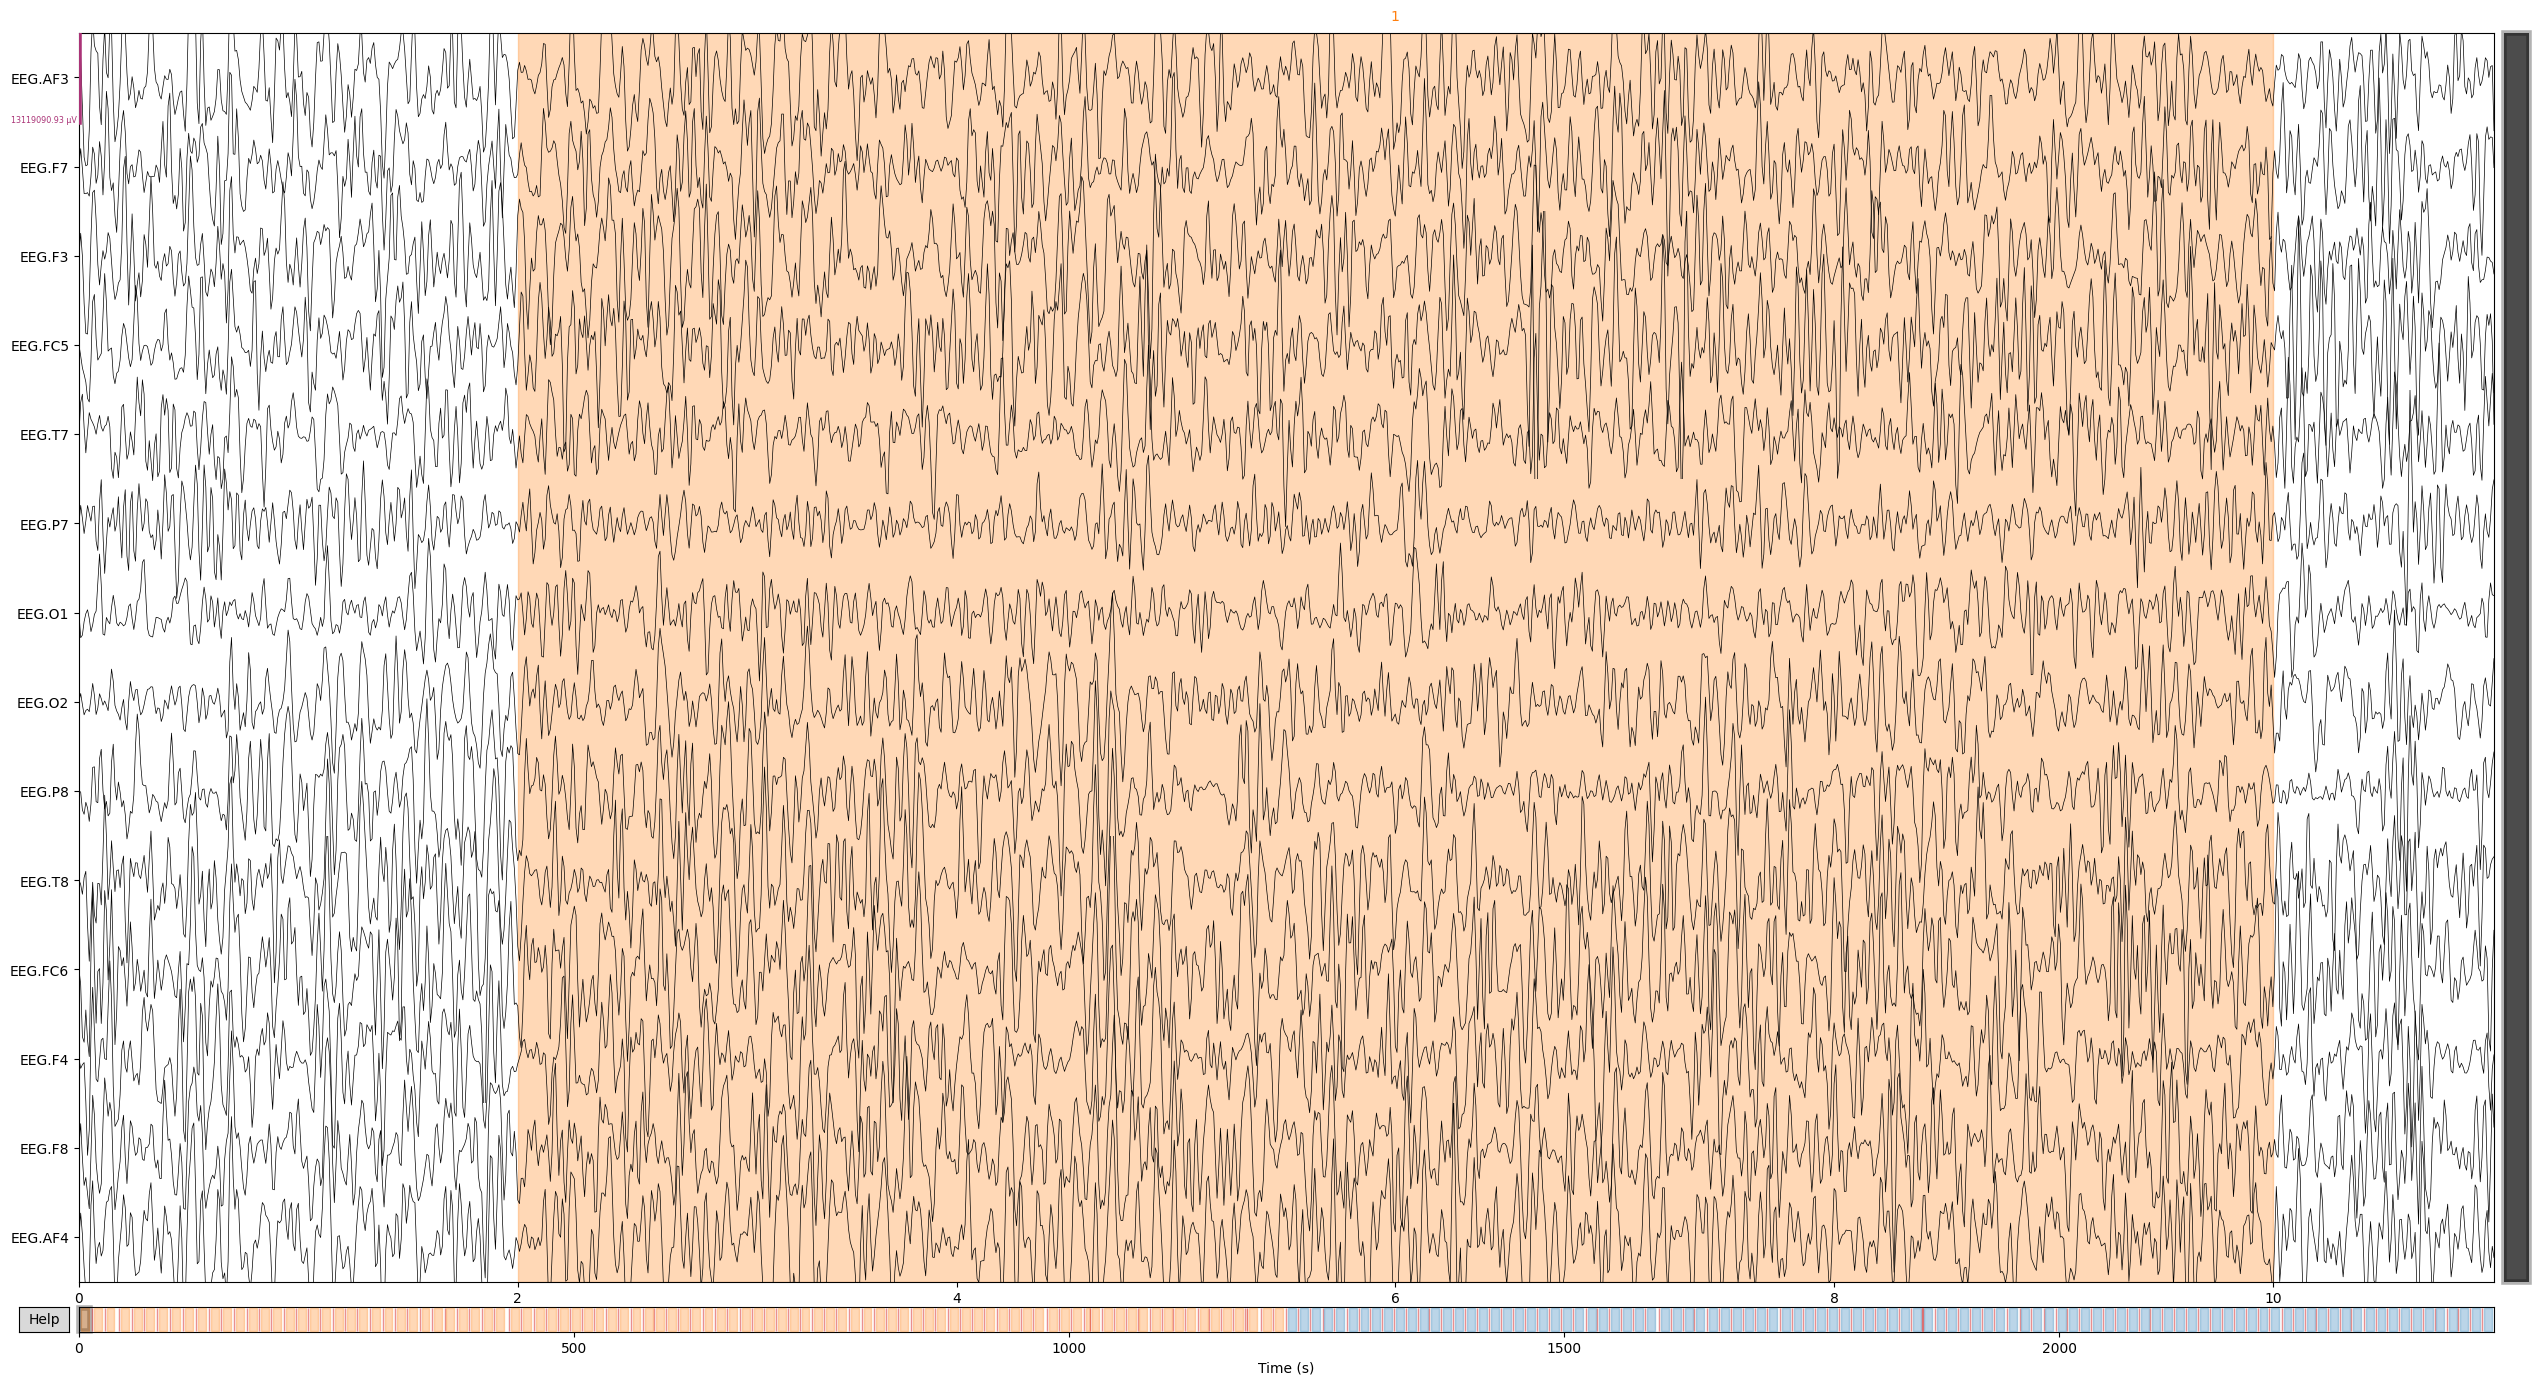

Raw data shape: (14, 312233)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


C:\Users\User\AppData\Local\Temp\ipykernel_8484\1540319902.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50, show=True)
c:\Users\User\anaconda3\envs\eeg\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


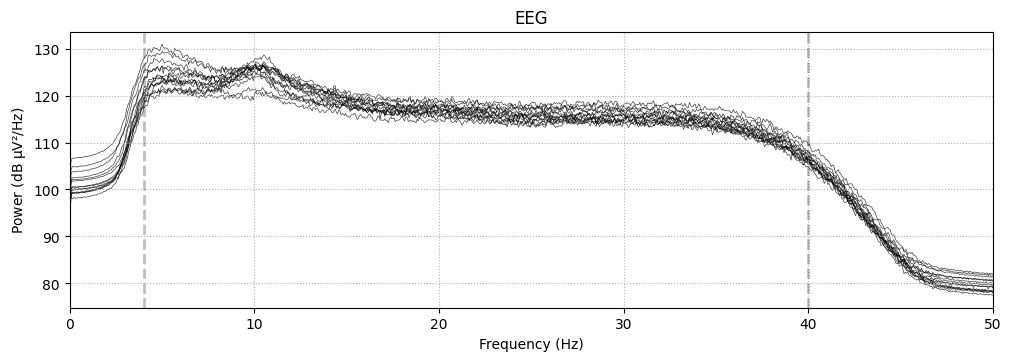

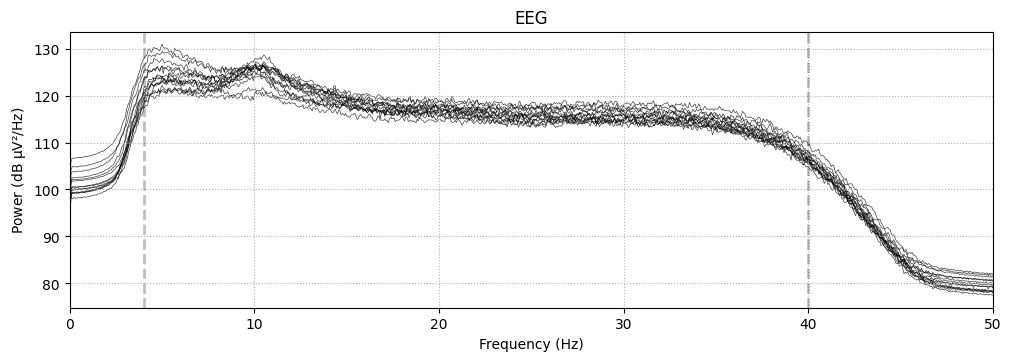

In [ ]:
import mne
import os
import matplotlib.pyplot as plt

fif_file = "/211_data_output/combined_test.fif"
raw = mne.io.read_raw_fif(fif_file, preload=True)
print(raw.info)
raw.plot(duration=11, n_channels=14, scalings='auto', title="EEG Data Plot")
print(f"Raw data shape: {raw.get_data().shape}")
raw.plot_psd(fmax=50, show=True)


In [ ]:
events, event_id = mne.events_from_annotations(combined_raw)


Used Annotations descriptions: [np.str_('0'), np.str_('1')]


In [ ]:
tmin = 0
tmax = 8

epochs = mne.Epochs(combined_raw, events, event_id=event_id, tmax=tmax, tmin=tmin,
                    reject=None, baseline=None, preload=True)

epoched_data = epochs.get_data(copy=True)
labels = epochs.events[:,-1]

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 1025 original time points ...
2 bad epochs dropped


In [ ]:
print("dataset shape:",epoched_data.shape)

dataset shape: (198, 14, 1025)


###Structuring Data

In [ ]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Normalizing Labels to [0, 1, 2, 3]
y = labels - np.min(labels)

# Normalizing Input features: z-score(mean=0, std=1)
X = (epoched_data - np.mean(epoched_data)) / np.std(epoched_data)

# Split Data: 80% for Train, 10% for Validation, and 10% for Test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

# Converting to Tensors
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_val = torch.Tensor(X_val).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_val = torch.LongTensor(y_val).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_val:", X_val.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_val:", y_val.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([96, 1, 14, 1025])
Size of X_val: torch.Size([42, 1, 14, 1025])
Size of X_test: torch.Size([60, 1, 14, 1025])
Size of y_train: torch.Size([96])
Size of y_val: torch.Size([42])
Size of y_test: torch.Size([60])


#Training Class

In [ ]:
class TrainModel():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, val_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        highest_val_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Training
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total

            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = val_correct / val_total
            if val_accuracy > highest_val_accuracy:
                highest_val_accuracy = val_accuracy

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {(val_accuracy*100):.2f}%")

        print("Highest Validation Accuracy:", highest_val_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model


#Evaluating Model

In [ ]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


#EEGNet Model

In [ ]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=14, classes=2, sample_rate=128, time_duration_in_seconds=8, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        time_points = sample_rate * time_duration_in_seconds
        time_points = 1025
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


##Model Summery

In [ ]:
input_size = (1, 14, 1025)
eegnet_model = EEGNetModel().to(device)
summary(eegnet_model, input_size)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 14, 1025]        --
|    └─Conv2d: 2-1                       [-1, 16, 14, 1025]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 14, 1025]        32
├─Sequential: 1-2                        [-1, 32, 1, 128]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1025]         448
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1025]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1025]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 128]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 128]          --
├─Sequential: 1-3                        [-1, 32, 1, 8]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 128]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 128]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 128]          64
|    └─EL

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 14, 1025]        --
|    └─Conv2d: 2-1                       [-1, 16, 14, 1025]        512
|    └─BatchNorm2d: 2-2                  [-1, 16, 14, 1025]        32
├─Sequential: 1-2                        [-1, 32, 1, 128]          --
|    └─Conv2d: 2-3                       [-1, 32, 1, 1025]         448
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 1025]         64
|    └─ELU: 2-5                          [-1, 32, 1, 1025]         --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 128]          --
|    └─Dropout: 2-7                      [-1, 32, 1, 128]          --
├─Sequential: 1-3                        [-1, 32, 1, 8]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 128]          512
|    └─Conv2d: 2-9                       [-1, 32, 1, 128]          1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 128]          64
|    └─EL

##Training Model

In [ ]:
eegnet_model = EEGNetModel().to(device)

# Training Hyperparameters
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel()
trained_eegnet_model = trainer.train_model(eegnet_model, train_dataset, val_dataset,
                                           learning_rate=LEARNING_RATE,
                                           batch_size=BATCH_SIZE,
                                           epochs=EPOCHS)
torch.save(trained_eegnet_model.state_dict(), 'eegnet_model.pth')


Epoch 1/500, Loss: 0.6983, Accuracy: 51.04%, Val Loss: 0.6947, Val Accuracy: 50.00%
Epoch 2/500, Loss: 0.6959, Accuracy: 48.96%, Val Loss: 0.6946, Val Accuracy: 50.00%
Epoch 3/500, Loss: 0.6817, Accuracy: 59.38%, Val Loss: 0.6944, Val Accuracy: 50.00%
Epoch 4/500, Loss: 0.6803, Accuracy: 60.42%, Val Loss: 0.6941, Val Accuracy: 50.00%
Epoch 5/500, Loss: 0.6712, Accuracy: 62.50%, Val Loss: 0.6935, Val Accuracy: 50.00%
Epoch 6/500, Loss: 0.6706, Accuracy: 57.29%, Val Loss: 0.6926, Val Accuracy: 50.00%
Epoch 7/500, Loss: 0.6785, Accuracy: 54.17%, Val Loss: 0.6911, Val Accuracy: 50.00%
Epoch 8/500, Loss: 0.6617, Accuracy: 55.21%, Val Loss: 0.6890, Val Accuracy: 50.00%
Epoch 9/500, Loss: 0.6546, Accuracy: 53.12%, Val Loss: 0.6859, Val Accuracy: 50.00%
Epoch 10/500, Loss: 0.6635, Accuracy: 56.25%, Val Loss: 0.6817, Val Accuracy: 50.00%
Epoch 11/500, Loss: 0.6497, Accuracy: 57.29%, Val Loss: 0.6762, Val Accuracy: 66.67%
Epoch 12/500, Loss: 0.6413, Accuracy: 61.46%, Val Loss: 0.6692, Val Accura

##Evaluating Model

/------------------------------/
Test Accuracy: 100.00%
/------------------------------/


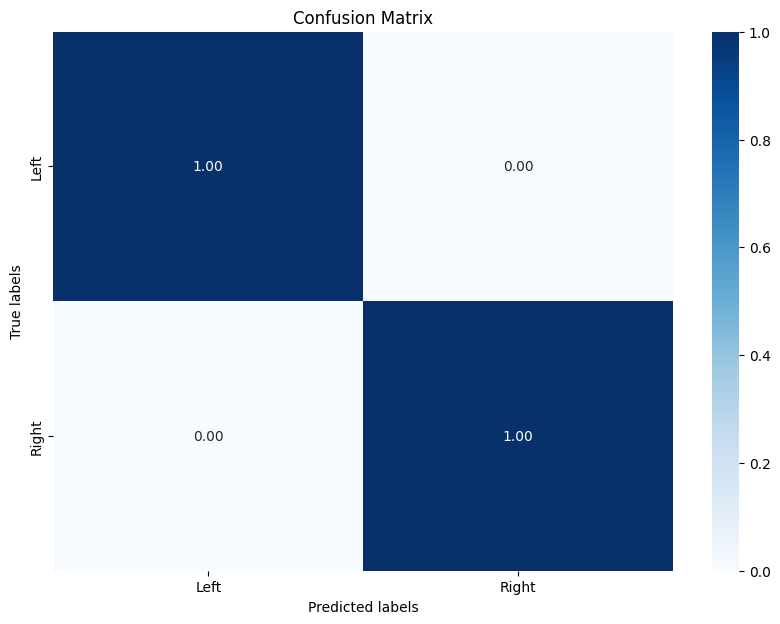

In [ ]:
classes_list = ['Left', 'Right']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)


In [ ]:
# Load new test data
new_test_file = './2_4_2025/left_test.csv'
new_test_df = pd.read_csv(new_test_file, skiprows=1)

# Extract EEG data
new_test_data = new_test_df[channel_names].values.T

# Create MNE RawArray object
new_test_info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
new_test_raw = mne.io.RawArray(new_test_data, new_test_info)

# Preprocess the new test data
new_test_raw.filter(l_freq=4, h_freq=40, method='iir')
new_test_raw.notch_filter(freqs=50)
new_test_data = new_test_raw.get_data()

# Normalize the new test data
new_test_data = (new_test_data - np.mean(new_test_data)) / np.std(new_test_data)
new_test_data = torch.Tensor(new_test_data).unsqueeze(0).unsqueeze(0).to(device)

# Load the trained model
trained_model = EEGNetModel().to(device)
trained_model.load_state_dict(torch.load('eegnet_model.pth'))
trained_model.eval()

# Make predictions
with torch.no_grad():
    outputs = trained_model(new_test_data)
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted class: {predicted.item()}")